# Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from trendfilter import trend_filter

# Data

In [57]:
train_events = pd.read_csv("train_events.csv")

In [58]:
series_has_NaN = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
no_NaN_series = series_has_NaN[~series_has_NaN].index.tolist()
# also drop these two "truncated" events series seen in EDA:
no_NaN_series.remove('31011ade7c0a') # incomplete events data
no_NaN_series.remove('a596ad0b82aa') # incomplete events data

In [59]:
def get_train_series(series):
    train_series = pd.read_parquet("train_series.parquet", filters=[('series_id','=',series)])
    train_events = pd.read_csv("train_events.csv").query('series_id == @series')
    
    train_events = train_events.dropna()
    train_events["step"]  = train_events["step"].astype("int")
    train_events["awake"] = train_events["event"].replace({"onset":1,"wakeup":0})

    train = pd.merge(train_series, train_events[['step','awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis ='rows')
    # final section:
    # train_events.groupby('series_id').tail(1)["event"].unique()
    # Result: the last event is always a "wakeup"
    train['awake'] = train['awake'].fillna(1) # awake
    train["awake"] = train["awake"].astype("int")
    return(train)

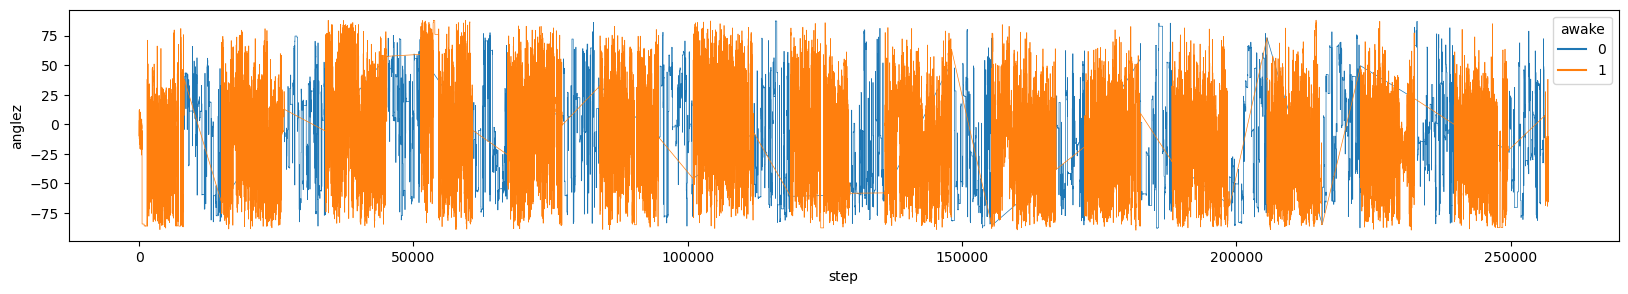

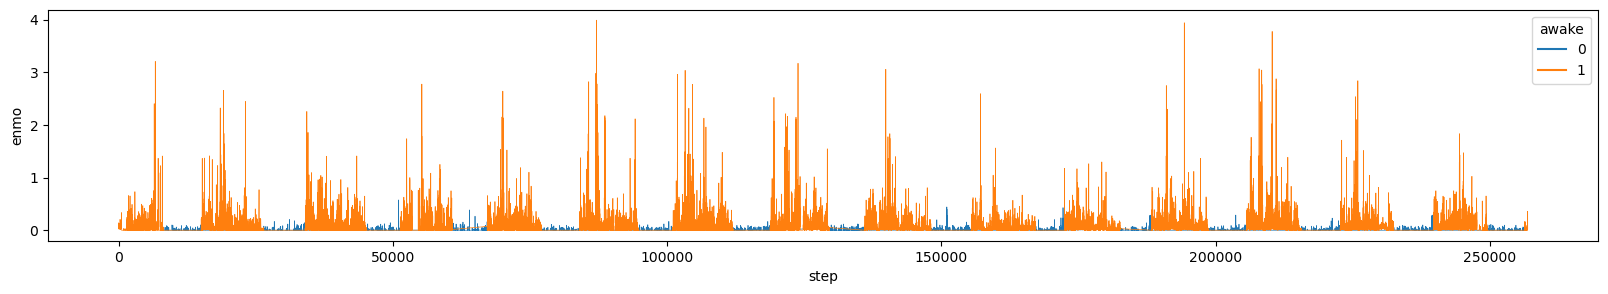

In [60]:
# Focus on data from one subject for now
train = get_train_series(no_NaN_series[1])
    
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
plt.show();
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
plt.show();

In [61]:
train

,series_id,step,timestamp,anglez,enmo,awake
0,0a96f4993bd7,0,2018-05-03T10:30:00-0400,3.272400,0.0386,1
1,0a96f4993bd7,1,2018-05-03T10:30:05-0400,0.073100,0.0663,1
2,0a96f4993bd7,2,2018-05-03T10:30:10-0400,-2.456300,0.0408,1
3,0a96f4993bd7,3,2018-05-03T10:30:15-0400,-5.466900,0.0820,1
4,0a96f4993bd7,4,2018-05-03T10:30:20-0400,-10.008800,0.0788,1
...,...,...,...,...,...,...
256855,0a96f4993bd7,256855,2018-05-18T07:14:35-0400,-62.247898,0.0153,1
256856,0a96f4993bd7,256856,2018-05-18T07:14:40-0400,-62.449299,0.0085,1
256857,0a96f4993bd7,256857,2018-05-18T07:14:45-0400,-61.691601,0.0095,1
256858,0a96f4993bd7,256858,2018-05-18T07:14:50-0400,-60.325699,0.0259,1


### Features

In [7]:
w = 5
median_enmo = train.enmo.rolling(w).median()

In [8]:
y = train.awake[w:-w]

In [9]:
median_enmo_before = median_enmo[w:-w]

In [10]:
median_enmo_after = median_enmo[(2*w):]

In [11]:
diff_anglez = pd.Series(np.abs(np.diff(train.anglez, prepend = 0)))
median_diff_anglez = diff_anglez.rolling(w).median()

In [12]:
median_diff_anglez_before = median_diff_anglez[w:-w]

In [13]:
median_diff_anglez_after = median_diff_anglez[(2*w):]

In [14]:
time = pd.to_datetime(train.timestamp).dt.hour[w:-w]

In [15]:
X = np.transpose(np.array([train.anglez[5:-5].values, train.enmo[5:-5].values,median_enmo_before.values, median_enmo_after.values, median_diff_anglez_before.values, median_diff_anglez_after.values]))

In [16]:
X.shape

(256850, 6)

### 1) Fit classifier

Logistic

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression(random_state=0).fit(X, y)
#clf = RandomForestClassifier().fit(X, y)
print(clf.score(X, y))
pred = clf.predict(X)

0.8829277788592563


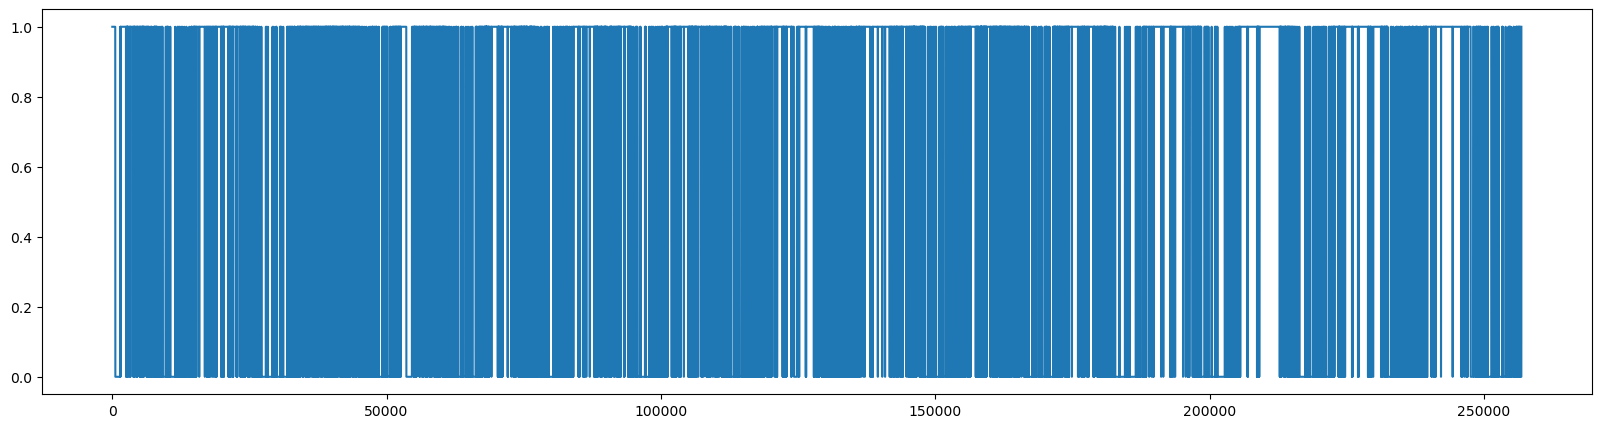

In [17]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.plot(pred)

### 2) Trend filtering

In [84]:
x = np.linspace(0, len(pred), len(pred))

In [85]:
tf = trend_filter(x, pred, l_norm=1, alpha_1=250)

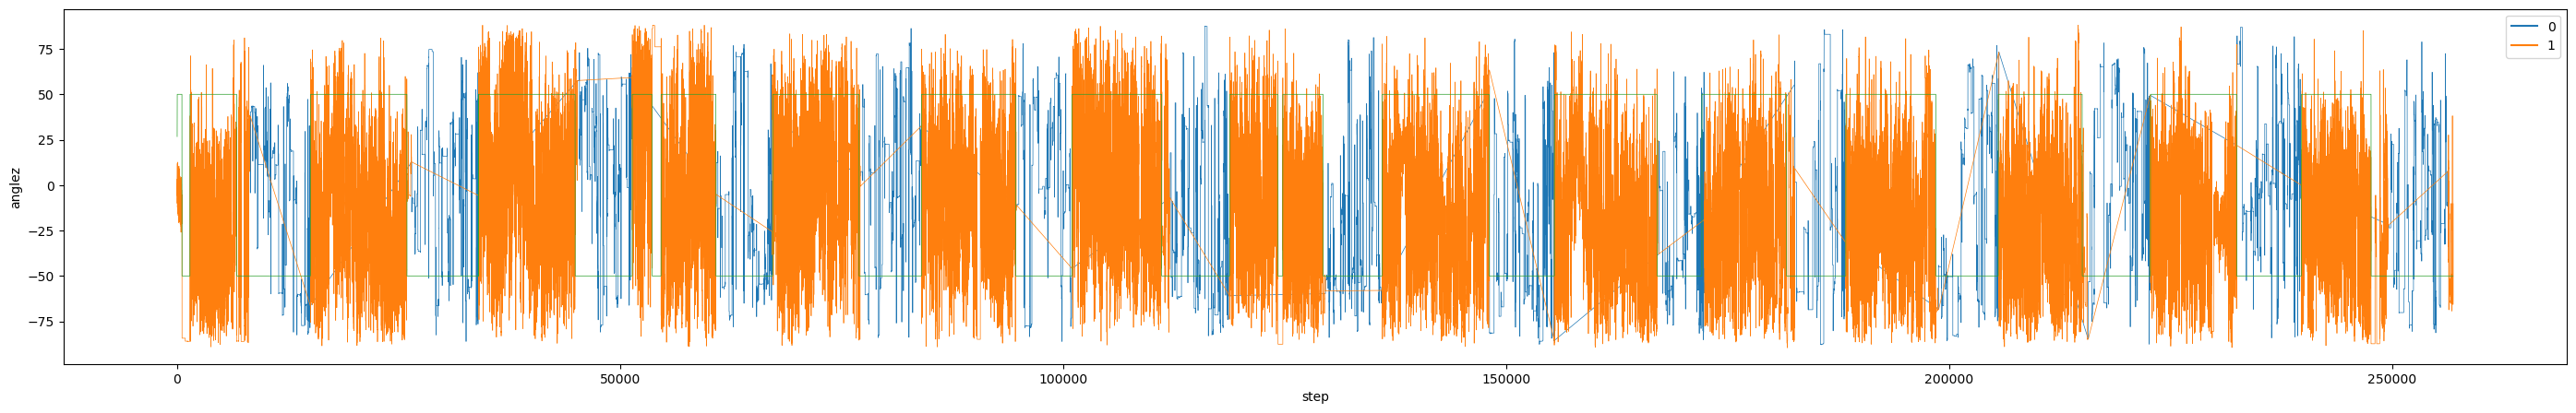

In [86]:
fig, ax = plt.subplots(figsize=(35, 5))
sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
sns.lineplot(np.append(tf['y_fit'][0], np.round(tf['y_fit'])) * 100 - 50, linewidth = 0.5)
plt.show();

In [ ]:
confusion_matrix = pd.crosstab(np.round(tf['y_fit']), y, rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0.0,98508,11406
1.0,384,146552


In [ ]:
accuracy = (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / np.sum(np.sum(confusion_matrix))
accuracy

0.9540977224060736

In [ ]:
pred = np.round(tf['y_fit'])
sum(pred[1:] != pred[:-1])

38

In [ ]:
sum(y.values[1:] != y.values[:-1])

30

In [ ]:
np.where(pred[1:] != pred[:-1])

(array([   536,   1441,   8106,  15045,  25930,  33981,  45049,  51331,
         53589,  54606,  60811,  67171,  77044,  83989,  94657, 100993,
        111993, 118757, 124240, 124772, 129349, 135967, 148087, 155412,
        167025, 172387, 182551, 188285, 198481, 205594, 215096, 222670,
        232427, 239710, 247597, 248566, 249459, 256310]),)

In [ ]:
np.where(y.values[1:] != y.values[:-1])

(array([  8251,  15019,  26455,  33967,  45151,  51331,  60811,  67171,
         77095,  83959,  94759, 100975, 112039, 118747, 129583, 135967,
        148087, 155407, 167191, 172387, 182551, 188263, 198799, 205591,
        215671, 222655, 232459, 239707, 249607, 256255]),)

### Predict on test data (another subject)

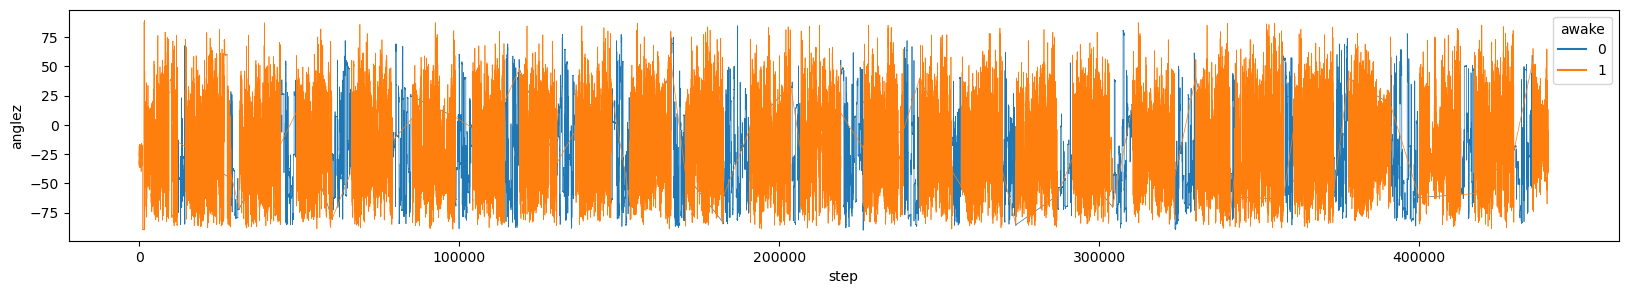

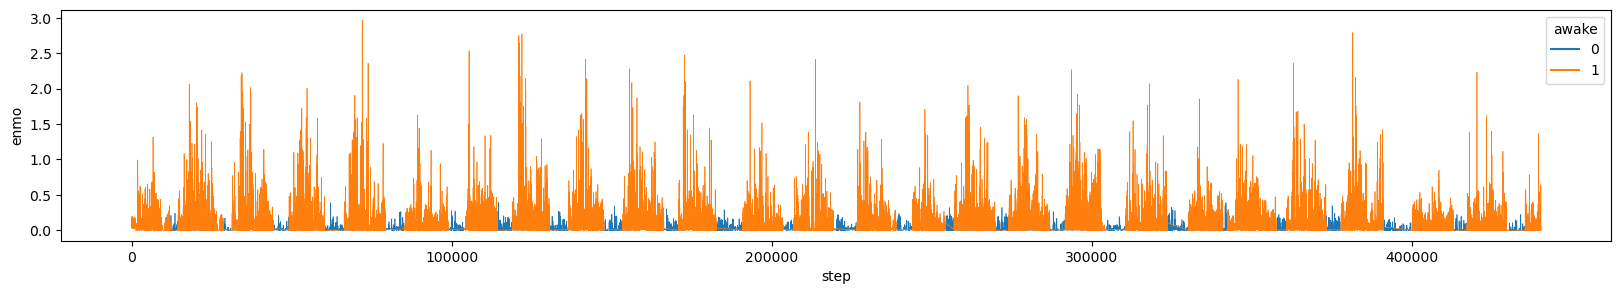

In [19]:
# Focus on data from one subject for now
test = get_train_series(no_NaN_series[0])
    
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=test, x="step", y="anglez",hue="awake", linewidth = 0.5)
plt.show();
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=test, x="step", y="enmo",hue="awake", linewidth = 0.5)
plt.show();

Construct features.

In [20]:
median_enmo = test.enmo.rolling(w).median()

In [21]:
y_test = test.awake[w:-w]

In [22]:
median_enmo_before = median_enmo[w:-w]

In [23]:
median_enmo_after = median_enmo[(2*w):]

In [24]:
diff_anglez = pd.Series(np.abs(np.diff(test.anglez, prepend = 0)))
median_diff_anglez = diff_anglez.rolling(w).median()

In [25]:
median_diff_anglez_before = median_diff_anglez[w:-w]

In [26]:
median_diff_anglez_after = median_diff_anglez[(2*w):]

In [64]:
#pd.to_datetime(test['timestamp'].values, format = '%Y-%m-%dT%H:%M:%S%z')

In [27]:
X_test = np.transpose(np.array([median_enmo_before.values, median_enmo_after.values, median_diff_anglez_before.values, median_diff_anglez_after.values]))

Predict with classifier.

In [66]:
pred_test = clf.predict(X_test)

In [67]:
confusion_matrix = pd.crosstab(pred_test, y_test, rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0,29060,5469
1,95848,309893


Improve prediction with trend filtering.

In [68]:
x = np.linspace(0, len(pred_test), len(pred_test))

In [73]:
tf = trend_filter(x, pred_test, l_norm=1, alpha_1=250)

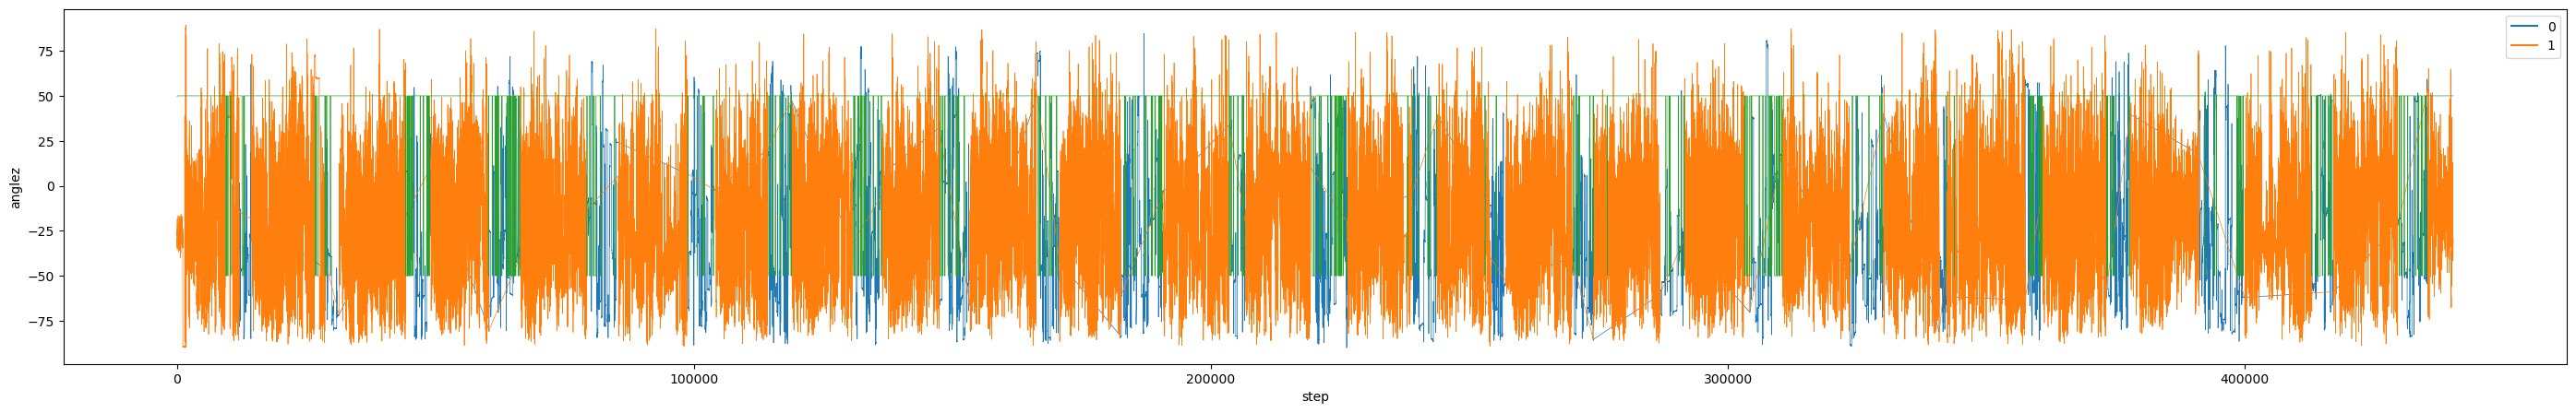

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))
sns.lineplot(data=test, x="step", y="anglez",hue="awake", linewidth = 0.5)
sns.lineplot(np.append(tf['y_fit'][0], np.round(tf['y_fit'])) * 100 - 50, linewidth = 0.5)
plt.show();

In [ ]:
confusion_matrix = pd.crosstab(np.round(tf['y_fit']), y_test, rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0.0,14689,1556
1.0,110219,313806


In [77]:
accuracy = (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / np.sum(np.sum(confusion_matrix))
accuracy

0.7461216980489245

In [78]:
pred = np.round(tf['y_fit'])
sum(pred[1:] != pred[:-1])

436

In [79]:
sum(y_test.values[1:] != y_test.values[:-1])

50

In [80]:
np.where(pred[1:] != pred[:-1])

(array([  9441,   9487,   9539,   9582,   9754,   9864,  10310,  10366,
         12538,  12741,  12935,  13007,  26672,  26707,  26769,  26804,
         27053,  27324,  28571,  28604,  28836,  28948,  29589,  29708,
         44207,  44241,  44291,  44603,  44636,  44667,  44795,  44900,
         44978,  45124,  45310,  45381,  45519,  45561,  46994,  47043,
         47612,  47671,  48293,  48386,  48446,  48486,  48552,  48602,
         48702,  48830,  60196,  60250,  60920,  60946,  61471,  61536,
         61709,  61763,  61802,  61838,  62008,  62044,  62126,  62164,
         62756,  62858,  63790,  63840,  63923,  64069,  64186,  64281,
         64455,  64552,  64674,  64851,  64924,  64958,  64995,  65031,
         65207,  65249,  65302,  65344,  65412,  65535,  65986,  66019,
         66163,  66321,  79200,  79389,  79771,  79852,  80425,  80513,
         80708,  81016,  81822,  81881,  84594,  84645,  98781,  98827,
        100596, 100628, 101696, 101755, 101885, 102018, 103699, 

In [81]:
np.where(y_test.values[1:] != y_test.values[:-1])

(array([ 11983,  14383,  28675,  31315,  44179,  49123,  60331,  66319,
         79147,  85267,  98815, 104071, 114199, 118831, 130555, 136255,
        147487, 153355, 166171, 170707, 182551, 190867, 203551, 206719,
        219235, 226387, 238807, 243847, 254083, 257071, 269791, 273943,
        286795, 291619, 304183, 310447, 323515, 330115, 340843, 342379,
        357487, 360787, 373171, 377815, 391111, 399955, 412951, 417175,
        429547, 435319]),)

Modify trend filtering to have similar number of change points as ground truth.

Random forest

In [29]:
clf_rf = RandomForestClassifier().fit(X, y)
print(clf_rf.score(X, y))
pred_rf = clf_rf.predict(X)

0.9591551489196029


In [18]:
# six features
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier().fit(X, y)
print(clf_rf.score(X, y))
pred_rf = clf_rf.predict(X)

0.9990811757835313


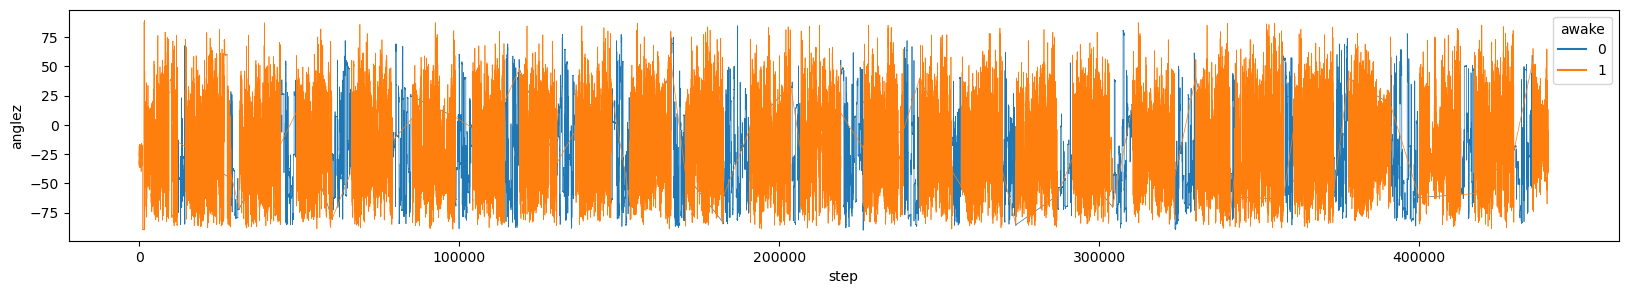

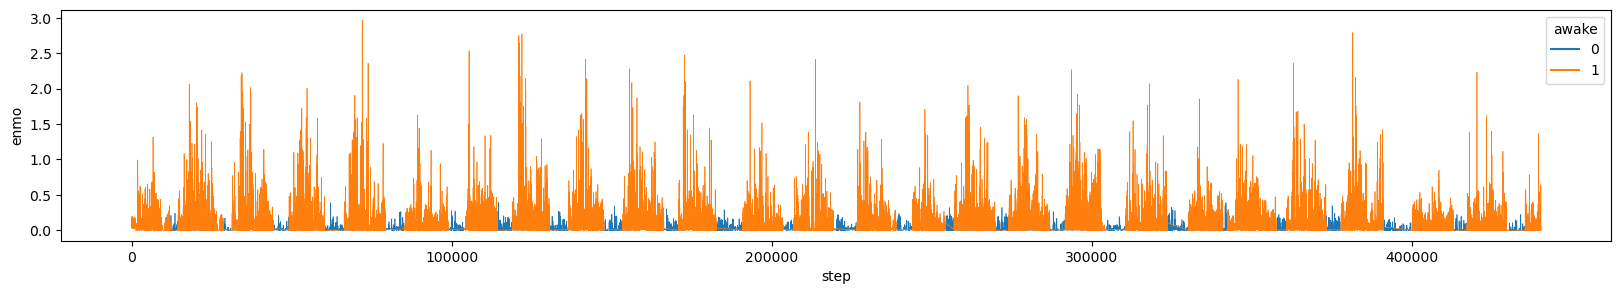

In [19]:
# test
# Focus on data from one subject for now
test = get_train_series(no_NaN_series[0])
    
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=test, x="step", y="anglez",hue="awake", linewidth = 0.5)
plt.show();
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=test, x="step", y="enmo",hue="awake", linewidth = 0.5)
plt.show();

In [27]:
def make_features(df,w):
    median_enmo = df.enmo.rolling(w).median()
    y = df.awake[w:-w]
    median_enmo_before = median_enmo[w:-w]
    median_enmo_after = median_enmo[(2*w):]
    diff_anglez = pd.Series(np.abs(np.diff(df.anglez, prepend = 0)))
    median_diff_anglez = diff_anglez.rolling(w).median()
    median_diff_anglez_before = median_diff_anglez[w:-w]
    median_diff_anglez_after = median_diff_anglez[(2*w):]
    X = np.transpose(np.array([df.anglez[5:-5].values, df.enmo[5:-5].values,median_enmo_before.values, 
                           median_enmo_after.values, median_diff_anglez_before.values, median_diff_anglez_after.values]))
    return X,y    

In [30]:
test.shape

(440280, 6)

In [28]:
X_test, y_test = make_features(test, w=5)

In [29]:
X_test.shape

(440270, 6)

In [31]:
pred_test = clf_rf.predict(X_test)
confusion_matrix = pd.crosstab(pred_test, y_test, rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0,32973,5530
1,91935,309832


In [32]:
accuracy = (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / np.sum(np.sum(confusion_matrix))
accuracy

0.7786244804324619

In [41]:
len(np.where(y_test.values[1:] != y_test.values[:-1])[0])

50

In [34]:
np.where(y_test.values[1:] != y_test.values[:-1])

(array([ 11983,  14383,  28675,  31315,  44179,  49123,  60331,  66319,
         79147,  85267,  98815, 104071, 114199, 118831, 130555, 136255,
        147487, 153355, 166171, 170707, 182551, 190867, 203551, 206719,
        219235, 226387, 238807, 243847, 254083, 257071, 269791, 273943,
        286795, 291619, 304183, 310447, 323515, 330115, 340843, 342379,
        357487, 360787, 373171, 377815, 391111, 399955, 412951, 417175,
        429547, 435319]),)

In [42]:
len(np.where(pred_test[1:] != pred_test[:-1])[0])

13106

In [33]:
np.where(pred_test[1:] != pred_test[:-1])

(array([  1174,   1175,   1391, ..., 435632, 437659, 437660]),)

Try yo use half of a series as traning, the rest as testing

In [83]:
train1 = train.copy()

In [84]:
train.shape

(128430, 6)

In [85]:
len(train1) 

128430

In [89]:
# Calculate midpoint index
midpoint_index = len(train1) // 2

# Split the DataFrame into training and testing sets
train = train1.iloc[:midpoint_index, :]
test = train1.iloc[midpoint_index:, :]


In [90]:
train.shape

(64215, 6)

In [91]:
test.shape

(64215, 6)

In [92]:
X_train, y_train =  make_features(train, w=5)
X_test, y_test = make_features(test, w=5)

/tmp/ipykernel_2113248/801347668.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y = df.awake[w:-w]
/tmp/ipykernel_2113248/801347668.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  median_enmo_before = median_enmo[w:-w]
/tmp/ipykernel_2113248/801347668.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old 

In [96]:
clf_rf = RandomForestClassifier().fit(X_train, y_train)
print(clf_rf.score(X_train, y_train))
pred_rf = clf_rf.predict(X_test)

0.9994548711159567


In [110]:
X_train.shape

(64205, 6)

In [103]:
pred_rf_train = clf_rf.predict(X_train)

In [106]:
np.where(y_train.values[1:] != y_train.values[:-1])

(array([ 8251, 15019, 26455, 33967, 45151, 51331, 60811]),)

In [109]:
np.where(pred_rf_train[1:] != pred_rf_train[:-1])

(array([ 8251, 15000, 26454, 33963, 45140, 51331, 60811]),)

In [105]:
y = train1.awake[w:-w]

In [107]:
np.where(y.values[1:] != y.values[:-1])

(array([  8251,  15019,  26455,  33967,  45151,  51331,  60811,  67171,
         77095,  83959,  94759, 100975, 112039, 118747]),)

In [97]:
confusion_matrix = pd.crosstab(pred_rf, y_test, rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0,14300,1615
1,8445,39845


In [100]:
np.where(y_test.values[1:] != y_test.values[:-1])

(array([ 2956, 12880, 19744, 30544, 36760, 47824, 54532]),)

In [102]:
len(np.where(pred_rf[1:] != pred_rf[:-1])[0])

1324

In [101]:
np.where(pred_rf[1:] != pred_rf[:-1])

(array([  163,   166,   202, ..., 64177, 64178, 64179]),)

In [112]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 447.6 kB/s eta 0:00:0000:0100:01�━━━━━━━━━━━━━╺━━━━━━━ 235.9/297.1 MB 18.1 MB/s eta 0:00:04�━━━━━━━━━━━━━━━━━╺ 290.5/297.1 MB 18.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


XGboost

In [113]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Initialize XGBoost classifier
clf_xgb = xgb.XGBClassifier()

# Specify the number of boosting rounds and early stopping criteria
num_boost_round = 1000
early_stopping_rounds = 10

# Train the model with early stopping
clf_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="error",  # You can use different metrics based on your task
    early_stopping_rounds=early_stopping_rounds,
    verbose=True
)

# Make predictions on the test set
y_pred = clf_xgb.predict(X_test)

/accounts/projects/sleepstates/.local/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/accounts/projects/sleepstates/.local/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.07253
[1]	validation_0-error:0.07347
[2]	validation_0-error:0.05850
[3]	validation_0-error:0.05791
[4]	validation_0-error:0.05786
[5]	validation_0-error:0.05735
[6]	validation_0-error:0.05771
[7]	validation_0-error:0.05721
[8]	validation_0-error:0.05771
[9]	validation_0-error:0.06894
[10]	validation_0-error:0.06870
[11]	validation_0-error:0.06475
[12]	validation_0-error:0.06708
[13]	validation_0-error:0.06929
[14]	validation_0-error:0.06892
[15]	validation_0-error:0.07099
[16]	validation_0-error:0.07183
[17]	validation_0-error:0.07186


In [115]:
np.where(y_pred[1:] != y_pred[:-1])

(array([  227,   237,   251,   254,   256,   260,   307,   310,   312,
          316,   441,   452,   642,   645,   738,   756,   757,   761,
          869,   882,   892,   902,   943,   946,   948,   952,  1173,
         1177,  1178,  1180,  1283,  1287,  1410,  1418,  2015,  2016,
         2039,  2046,  2087,  2096,  2109,  2119,  2124,  2128,  2129,
         2148,  2170,  2177,  2233,  2237,  2278,  2281,  2330,  2333,
         2411,  2413,  2421,  2428,  2443,  2447,  2448,  2452,  2456,
         2467,  2547,  2548,  2620,  2628,  2629,  2632,  2633,  2637,
         2665,  2669,  2670,  2673,  2676,  2678,  2753,  2772,  2773,
         2799,  2891,  2895,  2896,  2900,  2946,  2948,  2949,  2975,
         2978,  2986,  2998,  3701,  3717,  3722,  3726,  3727,  3738,
         3739,  3743,  4017,  4027,  4069,  4071,  4101,  4126,  4138,
         4142,  4143,  4147,  4276,  4280,  4281,  4305,  6190,  6194,
         6273,  6276,  6278,  6283,  6613,  6615,  6723,  6725,  6772,
      

In [114]:
np.where(y_test.values[1:] != y_test.values[:-1])

(array([ 2956, 12880, 19744, 30544, 36760, 47824, 54532]),)